

## 🔗 Concepto de correlación

### 🎯 Objetivos
- Entender **correlación positiva/negativa** entre activos.
- Ver cómo la **correlación** afecta la **volatilidad del portafolio**.
- Contrastar **mismo sector vs sectores distintos**.


### 1) ¿Qué es la correlación?

Correlation matrix

Pearson correlation coefficient:

$$\rho_{X,Y} = \frac {cov(X,Y)}{\sigma_X \sigma_Y} = \frac{E[(X-\mu_X)(Y-\mu_Y)]}{\sigma_X \sigma_Y}$$


La **correlación** (ρ) mide cómo se mueven **juntos** dos activos:
- **ρ ≈ +1 (positiva fuerte):** se mueven casi en la misma dirección.
- **ρ ≈ 0 (nula):** movimientos independientes.
- **ρ ≈ −1 (negativa fuerte):** se mueven en direcciones opuestas.

> En portafolios, **ρ más baja** (idealmente negativa) suele **reducir el riesgo** total.


### 2) ¿Por qué importa en la volatilidad del portafolio?
Para dos activos \( A \) y \( B \):

$$
\sigma_p^2 = w_A^2 \sigma_A^2 \;+\; w_B^2 \sigma_B^2 \;+\; 2\,w_A w_B\,\rho_{AB}\,\sigma_A \sigma_B
$$

- Si **ρ es baja/negativa**, el tercer término **reduce** la varianza ⇒ **menos volatilidad**.
- Si **ρ es alta y positiva**, ese término **aumenta** la varianza ⇒ **más volatilidad**.



### 3) Ejemplos típicos
- **Mismo sector (alta ρ):** AAPL–MSFT (Tecnología) tienden a moverse parecido ⇒ **diversifica poco**.
- **Sectores distintos (baja ρ):** XOM (Energía) vs JNJ (Salud), o un ETF de bonos (IEF/AGG) vs acciones ⇒ **mejor diversificación**.



### 🧪 Demo en Python con datos reales (yfinance)

Comparamos correlaciones entre pares “mismo sector” y “sectores distintos” y vemos el impacto en la volatilidad de un portafolio 50/50.

[*********************100%***********************]  5 of 5 completed


Matriz de correlación (2 años):
Ticker  AAPL   IEF   JNJ  MSFT   XOM
Ticker                              
AAPL    1.00  0.05  0.05  0.52  0.22
IEF     0.05  1.00  0.20 -0.06 -0.05
JNJ     0.05  0.20  1.00 -0.10  0.18
MSFT    0.52 -0.06 -0.10  1.00  0.03
XOM     0.22 -0.05  0.18  0.03  1.00

Volatilidades anuales (%):
Ticker
AAPL    27.77
IEF      7.07
JNJ     17.40
MSFT    22.53
XOM     22.16
dtype: float64

Comparación de pares y volatilidad del portafolio 50/50:
  Activo A Activo B  Correlación  Vol_Pfolio(50/50)_%
0     AAPL     MSFT         0.52                21.96
1     AAPL      JNJ         0.05                16.72
2     AAPL      XOM         0.22                19.60
3     AAPL      IEF         0.05                14.52


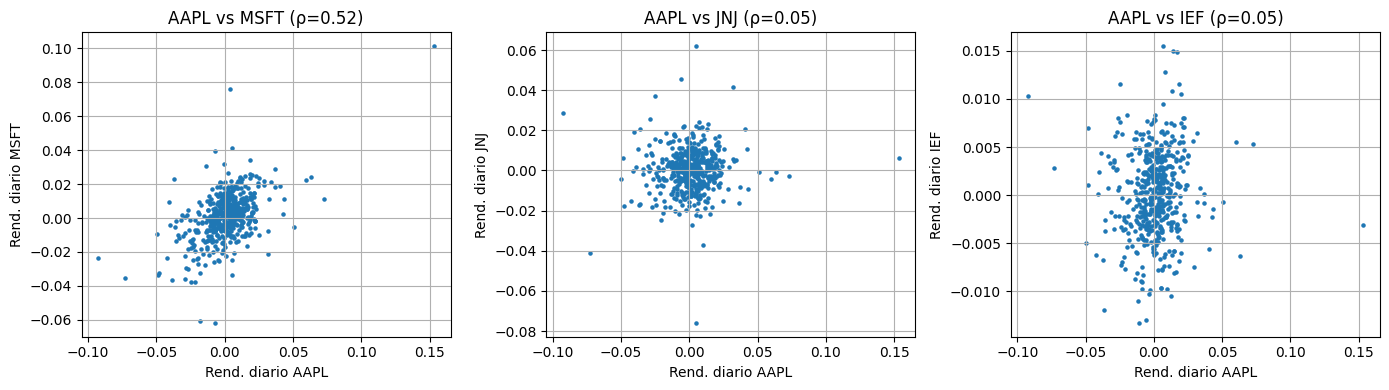

In [1]:
# !pip install yfinance --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Tickers: pares de mismo sector y de sectores distintos
# Tec vs Tec (alta ρ), Tec vs Salud/Energía/Bonos (ρ más baja)
tickers = ["AAPL","MSFT","JNJ","XOM","IEF"]  # IEF = bonos del Tesoro intermedios (proxy defensivo)
px = yf.download(tickers, period="2y" ,auto_adjust=True)["Close"].dropna()

# Rendimientos diarios y anualización
ret = px.pct_change().dropna()
corr = ret.corr()
vol = ret.std() * np.sqrt(252)      # volatilidad anual por activo
cov = ret.cov() * 252               # covarianza anual

print("Matriz de correlación (2 años):")
print(corr.round(2))
print("\nVolatilidades anuales (%):")
print((vol*100).round(2))

# Función para volatilidad de portafolio 2 activos, pesos 50/50
def port_vol_50_50(a, b):
    w = np.array([0.5, 0.5])
    sub_cov = cov.loc[[a,b], [a,b]].values
    return np.sqrt(w @ sub_cov @ w.T)

pares = [
    ("AAPL","MSFT"),  # mismo sector (tecnología)
    ("AAPL","JNJ"),   # tec vs salud
    ("AAPL","XOM"),   # tec vs energía
    ("AAPL","IEF"),   # tec vs bonos (defensivo)
]

rows = []
for a,b in pares:
    rho = corr.loc[a,b]
    pv  = port_vol_50_50(a,b)
    rows.append([a,b, rho, pv])

res = pd.DataFrame(rows, columns=["Activo A","Activo B","Correlación","Vol_Pfolio(50/50)"])
res["Vol_Pfolio(50/50)_%"] = (res["Vol_Pfolio(50/50)"]*100).round(2)
print("\nComparación de pares y volatilidad del portafolio 50/50:")
print(res[["Activo A","Activo B","Correlación","Vol_Pfolio(50/50)_%"]].round(2))

# (Opcional) Visual: dispersión AAPL vs cada activo (rendimientos diarios)
fig, axes = plt.subplots(1, 3, figsize=(14,4))
comparar = ["MSFT","JNJ","IEF"]
for i, tgt in enumerate(comparar):
    axes[i].scatter(ret["AAPL"], ret[tgt], s=5)
    axes[i].set_title(f"AAPL vs {tgt} (ρ={corr.loc['AAPL',tgt]:.2f})")
    axes[i].set_xlabel("Rend. diario AAPL")
    axes[i].set_ylabel(f"Rend. diario {tgt}")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

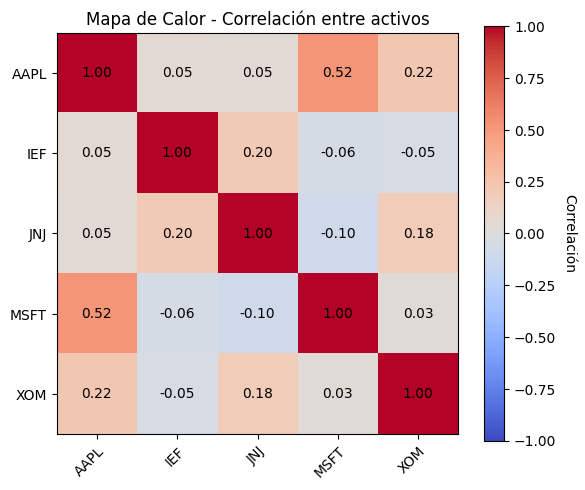

In [2]:
# --- 📊 Mapa de calor ---
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)

# Etiquetas en los ejes
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)

# Rotar etiquetas del eje X
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Agregar valores en cada celda
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        text = ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                       ha="center", va="center", color="black")

# Barra de color
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlación", rotation=-90, va="bottom")

ax.set_title("Mapa de Calor - Correlación entre activos")
plt.tight_layout()
plt.show()

### 🔍 Qué observar
*	Correlación AAPL–MSFT suele ser más alta ⇒ el portafolio 50/50 tiende a volatilidad mayor que mezclar AAPL con IEF.
*	AAPL–IEF (acciones–bonos) tiene correlación más baja ⇒ mejor reducción de riesgo.

### 🧠 Conclusión rápida
*	La diversificación no es tener muchos activos, es mezclar activos con baja correlación.
*	La correlación es la bisagra entre composición del portafolio y su volatilidad.
*	Lleva esto al siguiente bloque: construcción de portafolios eficientes (Markowitz) y frontera eficiente.



🔹 Lectura del gráfico

1.	Diagonal (1.00)
*	Cada activo con sí mismo tiene correlación perfecta (=1).
2.	AAPL – MSFT (0.52)
*	Correlación positiva y moderada.
*	Ambas son tecnológicas, suelen reaccionar parecido ante factores de mercado.
*	Diversificación limitada si se invierten en conjunto.
3.	AAPL – IEF (0.05)
*	Correlación casi nula.
*	Acciones (Apple) y bonos del Tesoro (IEF) no muestran relación clara.
*	Buena combinación para diversificar: uno puede compensar caídas del otro.
4.	MSFT – JNJ (-0.10)
*	Correlación ligeramente negativa.
*	Tecnología y salud tienen dinámicas diferentes, útil para cobertura parcial.
5.	IEF con la mayoría de acciones (-0.05 a 0.20)
*	Los bonos suelen moverse independientemente de las acciones.
*	Eso confirma su rol defensivo en un portafolio.
6.	XOM (energía) con el resto (0.18 – 0.22, salvo IEF -0.05)
*	Energía no está muy ligada a tech ni salud, lo que añade diversificación sectorial.

⸻

🔹 Interpretación práctica

*	Correlaciones altas positivas (>0.5): mueven casi igual, no ayudan a reducir riesgo (ej. AAPL–MSFT).
*	Cercanas a 0: aportan diversificación, ya que no siguen el mismo patrón (ej. AAPL–IEF).
*	Negativas (<0): son las más valiosas para cobertura, porque tienden a moverse en direcciones opuestas (ej. MSFT–JNJ).

⸻

🔹 Conclusión

El mapa confirma que:

*	Invertir solo en tecnología (AAPL, MSFT) no es suficiente para diversificar.
*	Incluir sectores distintos (salud con JNJ, energía con XOM) y sobre todo bonos (IEF) reduce el riesgo total porque las correlaciones son bajas o negativas.
*	La clave está en mezclar activos que no se muevan al unísono, construyendo así un portafolio más estable frente a cambios del mercado.

